# Data Description

This [dataset](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries/data) contains information about the jobs within the data science domain. It contains information about salaries, individual information like job title and expereience level, and information about the companies that people work at. 

The dataset includes 12 columns (listed below) and 606 observations.

The data was collected from ag-jobs.net.


| Column               | Description               | Data Type |
|----------------------|---------------------------|-----------|
| work_year            | The year the salary was paid.  |   integer        |
| experience_level     | The experience level in the job during the year with the following possible values: EN Entry-level / Junior, MI Mid-level / Intermediate, SE Senior level / Expert, EX Executive-level / Director. |     string      |
| employment_type      | The type of employment for the role: PT Part-time, FT Full-time, CT Contract, FL Freelance.|    string       |
| job_title            | The role worked in during the year.  |      string     |
| salary               | The total gross salary amount paid.  |    integer       |
| salary_currency      | The currency of the salary paid as an ISO 4217 currency code.  |     string      |
| salary_in_usd        | The salary in USD (FX rate divided by avg. USD rate for the respective year via fxdata.foorilla.com).   |     integer      |
| employee_residence   | Employee's primary country of residence during the work year as an ISO 3166 country code. |   string        |
| remote_ratio         | The overall amount of work done remotely, possible values are as follows: 0 No remote work (less than 20%), 50 Partially remote, 100 Fully remote (more than 80%). |      integer     |
| company_location     | The country of the employer's main office or contracting branch as an ISO 3166 country code. |    string       |
| company_size         | The average number of people that worked for the company during the year: S less than 50 employees (small), M 50 to 250 employees (medium), L more than 250 employees (large). |   integer        |

# Question

How does salary (in USD) vary based upon employee residence, company location, and remote_ratio?

We should be able to use the features `company_location` and `employee_residence` to gain a better understanding of how salary changes based upon the geography of a employee-company relationship, while `remote_ratio` will give us an idea of how the employee's location relates to the company in terms of work. 

This question leans more towards inference, given we want to see how these features change the salaries collected, but we can also create a predictive model and predict someone's future salary based on them. 

# Exploratory Data Analysis

> In this assignment, you will:
> * Demonstrate that the dataset can be loaded into R.
> * Clean and wrangle your data into a tidy format.
> * Propose a visualization that you consider relevant to address your question or to explore the data.
> * propose a high-quality plot or set of plots of the same kind (e.g., histograms of different variables)
> * explain why you consider this plot relevant to address your question or to explore the data


In [1]:
library(broom)
library(repr)
library(infer)
library(gridExtra)
library(faraway)
library(mltools)
library(leaps)
library(glmnet)
library(cowplot)
library(modelr)
library(tidyverse)

Loading required package: Matrix

Loaded glmnet 4.1-8


Attaching package: ‘modelr’


The following objects are masked from ‘package:mltools’:

    mse, rmse


The following object is masked from ‘package:broom’:

    bootstrap


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ modelr::bootstrap() masks broom::bootstrap()
✖ dplyr::combine()    masks gridExtra::combine()
✖ tidyr::expand()     masks Matrix::expand()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
✖ modelr::mse()       masks mltools::mse()
✖ tidyr::pack()       masks Matrix::pack()
✖ tidyr::replace_na() masks mltools::replace_na()
✖ modelr::rmse()      masks mltools::rmse()
✖ lubridate::stamp(

In [2]:
# load dataset
salaries = read_csv("data/ds_salaries.csv")

New names:
• `` -> `...1`
Rows: 607 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (7): experience_level, employment_type, job_title, salary_currency, empl...
dbl (5): ...1, work_year, salary, salary_in_usd, remote_ratio

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
# remove columns we don't need
salaries = salaries |> select(salary_in_usd, employee_residence, company_location, remote_ratio)
head(salaries)

salary_in_usd,employee_residence,company_location,remote_ratio
<dbl>,<chr>,<chr>,<dbl>
79833,DE,DE,0
260000,JP,JP,0
109024,GB,GB,50
20000,HN,HN,0
150000,US,US,50
72000,US,US,100


The graphs below are important for this project because it provides meaningfull analysis of which countries have the highest effect on salary when compared with remote status. This can give us an idea of how the model will predict if given one of the top 15 countries. (We use only the top 15 because there are too many to include in a graph)

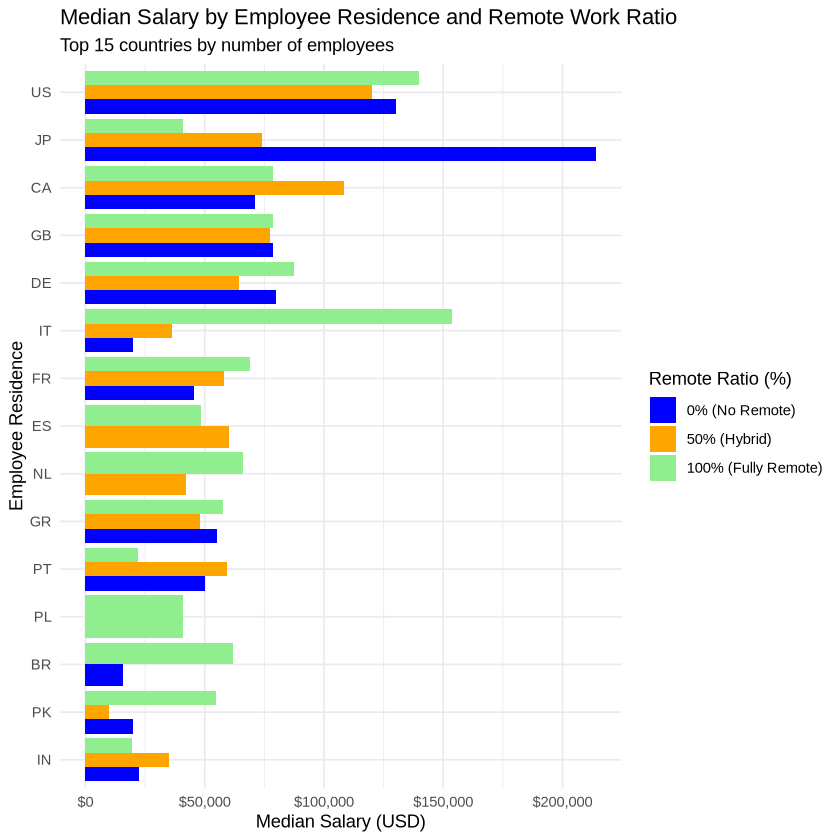

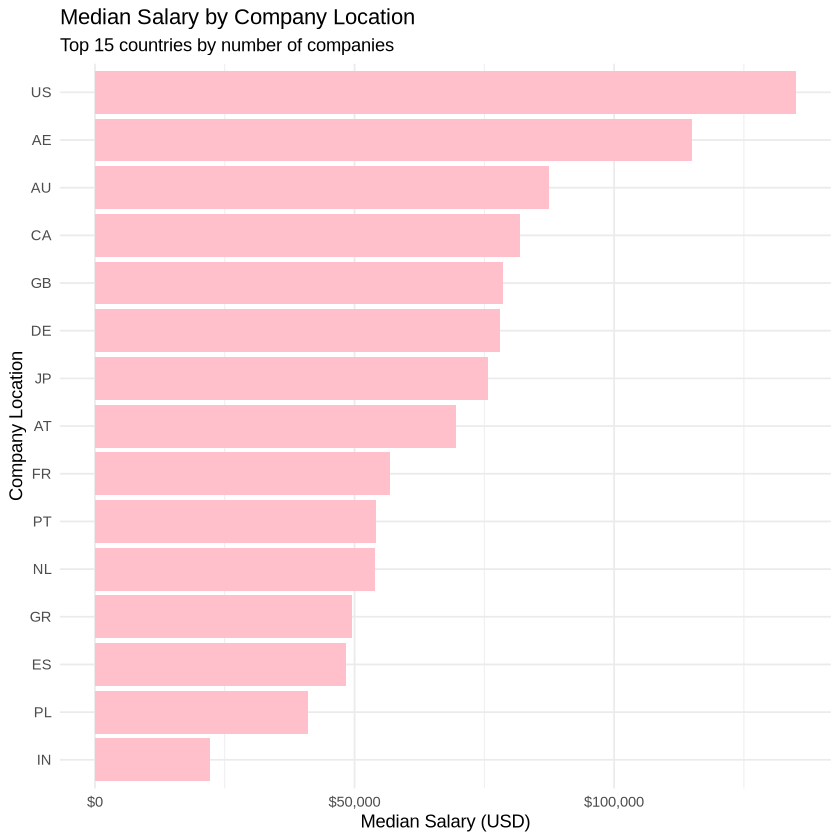

In [9]:
top_countries <- salaries %>%
  count(employee_residence) %>%
  arrange(desc(n)) %>%
  head(15) %>%
  pull(employee_residence)

# find the medians
location_summary <- salaries %>%
  filter(employee_residence %in% top_countries) %>%
  group_by(employee_residence, remote_ratio) %>%
  summarise(
    median_salary = median(salary_in_usd),
    n = n(),
    .groups = 'drop'
  )

ggplot(location_summary, 
       aes(x = reorder(employee_residence, median_salary), 
           y = median_salary, 
           fill = as.factor(remote_ratio))) +
  geom_bar(stat = "identity", position = "dodge") +
  scale_y_continuous(labels = scales::dollar_format()) +
  coord_flip() +
  labs(
    title = "Median Salary by Employee Residence and Remote Work Ratio",
    subtitle = "Top 15 countries by number of employees",
    x = "Employee Residence",
    y = "Median Salary (USD)",
    fill = "Remote Ratio (%)"
  ) +
  scale_fill_manual(values = c("blue", "orange", "lightgreen"), 
                    labels = c("0% (No Remote)", "50% (Hybrid)", "100% (Fully Remote)")) +
  theme_minimal()

top_countries <- salaries %>%
  count(company_location) %>%
  arrange(desc(n)) %>%
  head(15) %>%
  pull(company_location)

# find the medians
location_summary <- salaries %>%
  filter(company_location %in% top_countries) %>%
  group_by(company_location) %>%
  summarise(
    median_salary = median(salary_in_usd),
    n = n(),
    .groups = 'drop'
  )

ggplot(location_summary, 
       aes(x = reorder(company_location, median_salary), 
           y = median_salary)) +
  geom_bar(stat = "identity", position = "dodge", fill="pink") +
  scale_y_continuous(labels = scales::dollar_format()) +
  coord_flip() +
  labs(
    title = "Median Salary by Company Location",
    subtitle = "Top 15 countries by number of companies",
    x = "Company Location",
    y = "Median Salary (USD)"
  ) +
  theme_minimal()